### Import Dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [5]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

In [6]:
dataset = datasets.ImageFolder(r"C:\Users\ramad\OneDrive\Desktop\Files\plant dataset", transform=transform)

In [7]:
dataset

Dataset ImageFolder
    Number of datapoints: 55448
    Root location: C:\Users\ramad\OneDrive\Desktop\Files\plant dataset
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [8]:
indices = list(range(len(dataset)))

In [9]:
split = int(np.floor(0.85 * len(dataset)))  # train_size

In [10]:
validation = int(np.floor(0.70 * split))  # validation

In [11]:
print(0, validation, split, len(dataset))

0 32991 47130 55448


In [12]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :32991
length of validation size :14139
length of test size :22457


In [13]:
np.random.shuffle(indices)

### Split into Train and Test

In [15]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [16]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [17]:
targets_size = len(dataset.class_to_idx)

### Model

In [25]:
model = models.vgg16(pretrained=True)

c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
for params in model.parameters():
    params.requires_grad = False

In [27]:
n_features = model.classifier[0].in_features
n_features

25088

In [28]:
model.classifier = nn.Sequential(
    nn.Linear(n_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, targets_size),
    )

In [29]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [38]:
device = "cpu"

In [39]:
model = CNN(targets_size)

In [40]:
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [41]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

In [42]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

### Batch Gradient Descent

In [32]:
def batch_gd(model, criterion, train_loader, validation_losses, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [33]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [34]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 2
)

Epoch : 1/2 Train_loss:1.222 Test_loss:1.091 Duration:2:15:53.636764
Epoch : 2/2 Train_loss:1.007 Test_loss:0.998 Duration:2:25:58.859334


### Save the Model

In [35]:
torch.save(model.state_dict() , 'plant_disease_model_1.pt')

### Load Model

In [37]:
targets_size = 39
model = CNN(targets_size)
model.load_state_dict(torch.load(r"C:\Users\ramad\OneDrive\Desktop\Plant Disease Detection\Flask\plant_disease_model_1_latest.pt"))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

### Plot the loss

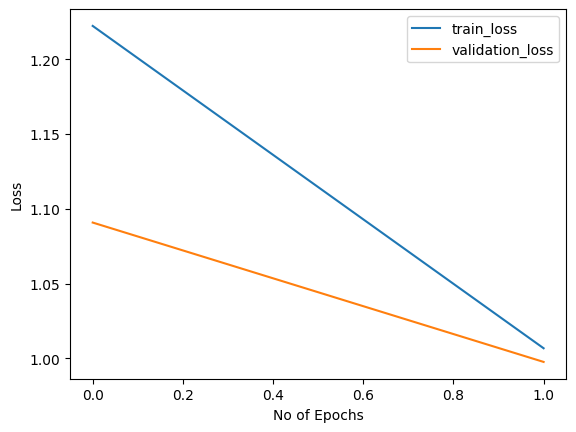

In [38]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

In [39]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [40]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

In [41]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.9385286896426298
Test Accuracy : 0.9371243087280596
Validation Accuracy : 0.9368413607751609


In [ ]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        # ... (existing code)

        train_loss = np.mean(train_loss)

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        # Calculate precision during training
        train_precision = precision(model, train_loader)
        validation_precision = precision(model, validation_loader)

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Train_precision:{train_precision:.3f} Validation_precision:{validation_precision:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

def precision(model, loader):
    model.eval()
    n_correct = 0
    n_predicted_positive = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            n_correct += ((predictions == targets) & (targets == 1)).sum().item()
            n_predicted_positive += (predictions == 1).sum().item()

    precision = n_correct / n_predicted_positive if n_predicted_positive > 0 else 0
    return precision


In [ ]:
test_precision = precision(model, test_loader)
print(f"Test Precision: {test_precision:.3f}")

### Single Image Prediction

In [45]:
transform_index_to_disease = dataset.class_to_idx

In [46]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)

In [48]:
data = pd.read_csv(r"C:\Users\ramad\OneDrive\Desktop\Plant Disease Detection\Flask\disease_info.csv", encoding="cp1252")

In [49]:
from PIL import Image
import torchvision.transforms.functional as TF

In [50]:
def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data)
    output = output.detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[12:-4])
    pred_csv = data["disease_name"][index]
    print(pred_csv)

Original :  ad\OneDrive\Desktop\Files\plant dataset\Apple___Apple_scab\image (3)
Apple : Scab


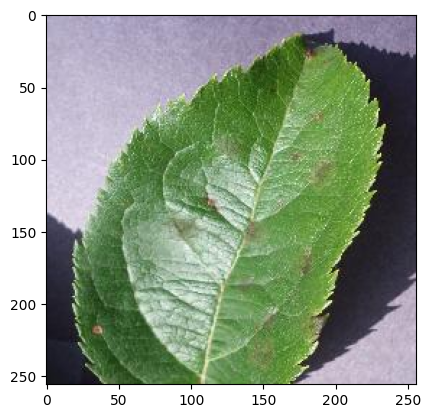

In [59]:
img = plt.imread(r"C:\Users\ramad\OneDrive\Desktop\Files\plant dataset\Apple___Apple_scab\image (3).JPG")
fig, ax = plt.subplots()
ax.imshow(img)
single_prediction(r"C:\Users\ramad\OneDrive\Desktop\Files\plant dataset\Apple___Apple_scab\image (3).JPG")

Original :  ad\OneDrive\Desktop\Files\plant dataset\Corn___Common_rust\image (13)
Corn : Common Rust


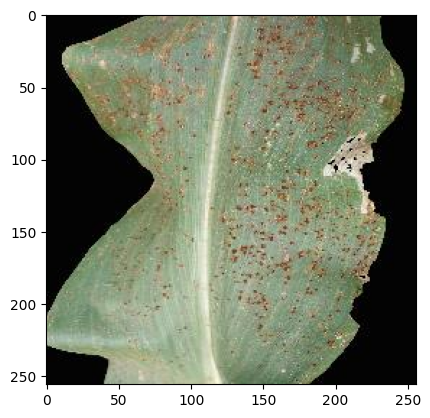

In [58]:
img = plt.imread(r"C:\Users\ramad\OneDrive\Desktop\Files\plant dataset\Corn___Common_rust\image (13).JPG")
fig, ax = plt.subplots()
ax.imshow(img)
single_prediction(r"C:\Users\ramad\OneDrive\Desktop\Files\plant dataset\Corn___Common_rust\image (13).JPG")

Original :  ad\OneDrive\Desktop\Files\plant dataset\Potato___healthy\image (14)
Potato : Healthy


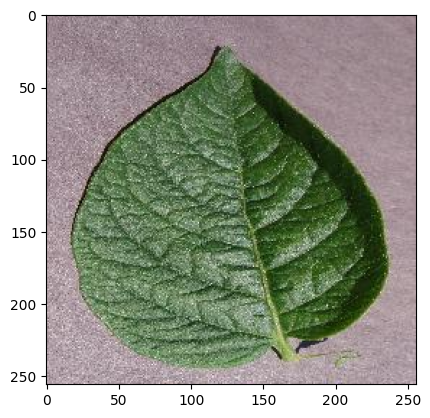

In [57]:
img = plt.imread(r"C:\Users\ramad\OneDrive\Desktop\Files\plant dataset\Potato___healthy\image (14).JPG")
fig, ax = plt.subplots()
ax.imshow(img)
single_prediction(r"C:\Users\ramad\OneDrive\Desktop\Files\plant dataset\Potato___healthy\image (14).JPG")

Original :  ad\OneDrive\Desktop\Files\plant dataset\Pepper,_bell___Bacterial_spot\image (8)
Pepper bell : Bacterial Spot


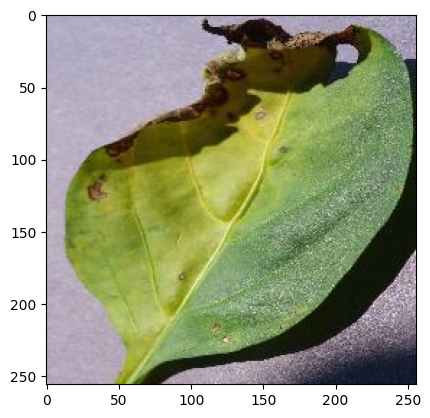

In [56]:
img = plt.imread(r"C:\Users\ramad\OneDrive\Desktop\Files\plant dataset\Pepper,_bell___Bacterial_spot\image (8).JPG")
fig, ax = plt.subplots()
ax.imshow(img)
single_prediction(r"C:\Users\ramad\OneDrive\Desktop\Files\plant dataset\Pepper,_bell___Bacterial_spot\image (8).JPG")